# Transcriptomics-to-Histology Alignment of Human  Breast and Lung Cancers

In this experiment, we showcase GALA’s ability to perform **cross-modal alignment**, connecting single-cell transcriptomics to paired H&E histology images. Two datasets are used:

- **Human Breast Cancer ([Situ Sample 1 Replicate 1](https://www.10xgenomics.com/products/xenium-in-situ/preview-dataset-human-breast)):**  

- **Human Lung Cancer ([Xenium v1, FFPE](https://www.10xgenomics.com/datasets/xenium-human-lung-cancer-post-xenium-technote)) from 10x Genomics:**  


Here, the H&E image is considered the **source**, and the transcriptomics data is the **target**, reflecting the high-resolution nature of the histology image. GALA computes a **diffeomorphic mapping** from the image to the transcriptomics data, enabling pixel- or cell-level correspondence. The **inverse mapping** allows the transcriptomics features to be projected back onto the tissue image, effectively achieving **transcriptomics-to-histology alignment**.  

This experiment demonstrates how GALA bridges molecular and morphological information, enabling integrated analysis of spatial transcriptomics and histology.

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import time 
import torch
import matplotlib.gridspec as gridspec
import cv2
import os
import anndata as ad

import warnings
for cat in [FutureWarning, DeprecationWarning]:
    warnings.filterwarnings("ignore", category=cat)

# data loading path
data_path = os.path.expanduser('../Data')  # Update this path to your data directory  
results_path = os.path.expanduser('./Results/tutorials')  # Directory to save results
os.makedirs(results_path, exist_ok=True)

# Human Breast Cancers


## Load data and Rasterise of H&E Image and Transcriptomics Data

- **Source (H&E image):**  
  The image is converted to grayscale, and gradient magnitudes are computed using Sobel filters to capture morphological features. The resulting feature map is normalised and rasterized for downstream alignment.  

- **Target (Transcriptomics):**  
  Single-cell RNA-seq counts are rasterized onto a grid at 30 $\mu m$ resolution, using the total transcript counts per cell as the signal.  

This setup allows GALA to compute a spatially consistent mapping from image features to transcriptomics data, enabling pixel-to-cell correspondence across modalities.

In [2]:
from GALA.utils import  rasterize,normalize
# Source is H&E staining image
img = plt.imread(os.path.join(data_path, './HBC/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.png'))
V = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
sobelx = cv2.Sobel(V, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(V, cv2.CV_64F, 0, 1, ksize=3)
I = normalize(cv2.magnitude(sobelx, sobely))
I  = I[None,...]

YI = np.array(range(I.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
XI = np.array(range(I.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.

### Target Data
slice2 =  sc.read_h5ad(os.path.join(data_path, './HBC/Breast_Cancer_Rep1.h5ad'))
g = np.array(slice2.X.sum(axis = 1))
sc.pp.normalize_total(slice2, inplace=True)
sc.pp.log1p(slice2)
### Generate the data for experiments
xj = slice2.obsm['spatial'][:,0]
yj = slice2.obsm['spatial'][:,1]
gj = np.array(slice2.X.sum(axis = 1))
# rasterize at 30um resolution (assuming positions are in um units) and plot
XJ,YJ,J = rasterize(xj,yj,g = gj, dx=30)

xI = [YI,XI]
xJ = [YJ,XJ]


/home/zeng/anaconda3/envs/tao/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/zeng/anaconda3/envs/tao/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:235: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


0 of 167780
10000 of 167780
20000 of 167780
30000 of 167780
40000 of 167780
50000 of 167780
60000 of 167780
70000 of 167780
80000 of 167780
90000 of 167780
100000 of 167780
110000 of 167780
120000 of 167780
130000 of 167780
140000 of 167780
150000 of 167780
160000 of 167780
167779 of 167780


Transcriptomics-to-Histology Data Overview

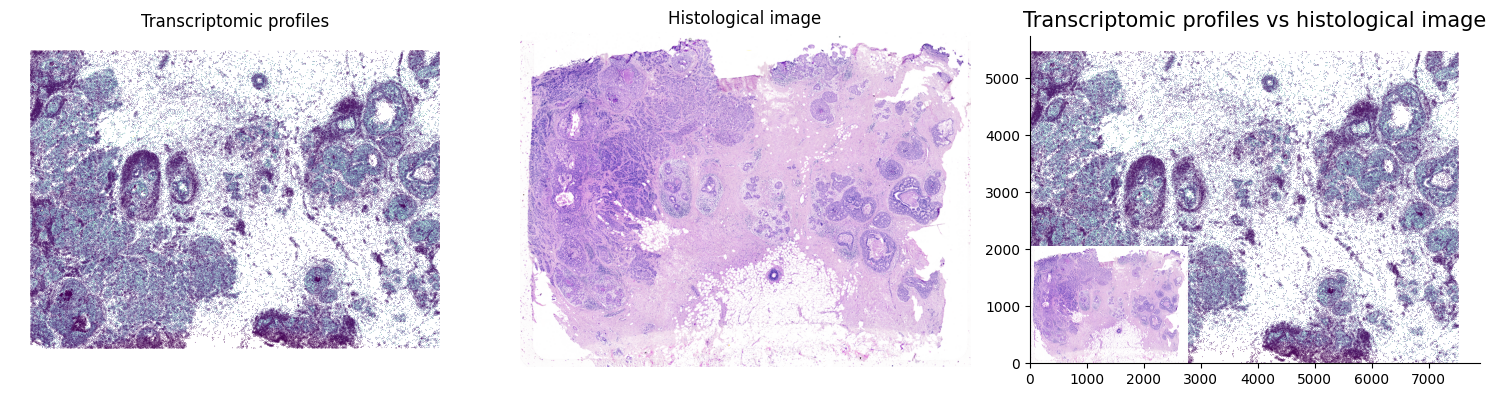

In [3]:
fs = 15
ps = 1

fig,axs = plt.subplots(1,3,figsize=(15, 5))
 
axs[0].scatter(xj,yj,s = ps,alpha = 1,c = g,cmap = 'viridis',linewidths=0,marker = '.')
axs[0].axis('off')
axs[0].set_title('Transcriptomic profiles')
axs[0].set_aspect('equal') 


axs[1].imshow(img)
axs[1].axis('off')
axs[1].set_title('Histological image')
axs[1].set_aspect('equal') 
axs[1].invert_yaxis()

axs[2].imshow(img,zorder = 1)
axs[2].scatter(xj,yj,s = ps,alpha = 1,zorder = 0,c = g,cmap = 'viridis',linewidths=0,marker = '.')
axs[2].set_title('Transcriptomic profiles vs histological image',fontsize = fs)
#ax.axis('off')
axs[2].invert_yaxis()
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
#ax3.set_xlabel('Spatial 1')
#ax3.set_ylabel('Spatial 2')


plt.tight_layout()
plt.show()


Rasterised Views of molecular and morphology

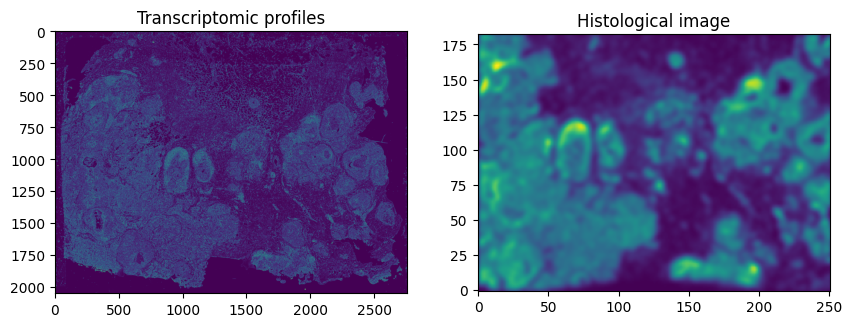

In [4]:
fig,axs = plt.subplots(1,2,figsize=(10, 5))
 
axs[0].imshow(I[0])
axs[0].set_title('Transcriptomic profiles')

axs[1].imshow(J[0])
axs[1].set_title('Histological image')
axs[1].invert_yaxis()

plt.tight_layout
plt.show()

## GALA

In [5]:
from GALA.gala import gala
from GALA.utils import to_cpu

rIy = xI[0].max() - xI[0].min()
rIx = xI[1].max() - xI[1].min()
rJy = xJ[0].max() - xJ[0].min()
rJx = xJ[1].max() - xJ[1].min()
sx_range = rIx / rJx if rIx > rJx else rJx / rIx  
sy_range = rIy / rJy if rIy > rJy else rJy / rIy
gene_space = [
    {},     # angle
    {'low': 0.01, 'high': (sy_range+1.5)},     # sy
    {'low': -(sx_range+1.5), 'high': (sx_range+1.5)},     # sx
    {},     # ty
    {},     # tx
]

params = {'num_generations' : 1000,
          'num_iterations': 2000,
          'num_repeats': 2,
          'epV': 10.0,
          'a': 20.0,
          'sigmaR':5e4,
          'sigmaM': I.std(),
          'sigmaB': J.std(),
          'random_seed': 42
          }
start = time.time()
resu = gala(xI,I,xJ,J,gene_space = gene_space, **params)
print('Alignment Runtime: ' + str(time.time() - start)) 


# save resu and copy results to CPU if gala runs on GPU.
if torch.cuda.is_available():
    resu = to_cpu(resu)
    
# with open(os.path.join(results_path, "bct.pkl"), 'wb') as f:
#     pickle.dump(resu, f)


Iteration 1 of 2
Generation = 200
Fitness    = 0.0005250375251886524
Change     = 0.0005250375251886524
Generation = 400
Fitness    = 0.0005338600528074223
Change     = 8.822527618769873e-06
Generation = 600
Fitness    = 0.0005338600528074223
Change     = 0.0
Generation = 800
Fitness    = 0.0005340305206529343
Change     = 1.7046784551197174e-07
Generation = 1000
Fitness    = 0.0005340771227434725
Change     = 4.660209053819909e-08
Best transformation: angle=179.65, sx=-3.63, sy=3.65, tx=-169.31, ty=509.10
0 of 2000
500 of 2000
1000 of 2000
1500 of 2000
1999 of 2000
Iteration 2 of 2
Generation = 200
Fitness    = 0.0005250375251886524
Change     = -9.039597554820044e-06
Generation = 400
Fitness    = 0.0005338600528074223
Change     = 8.822527618769873e-06
Generation = 600
Fitness    = 0.0005338600528074223
Change     = 0.0
Generation = 800
Fitness    = 0.0005340305206529343
Change     = 1.7046784551197174e-07
Generation = 1000
Fitness    = 0.0005340771227434725
Change     = 4.6602090538

## Transcriptomics-to-Histology Alignment Result (Inverse Mapping)

In this experiment, the **high-resolution H&E image** is treated as the **source**, and the transcriptomic data as the **target**.  

- Using GALA, we first align the **image to transcriptomics** (source → target).  
- To map transcriptomic spots onto the histology, we compute the **inverse mapping** \((\phi^v(A(x)))^{-1}\), effectively transforming target coordinates into the source image space.  
- The H&E image is shown in the background, and transcriptomic spots are overlaid, coloured by **total counts per cell**.  

This highlights GALA’s ability to perform **inverse, cross-modal alignment**, linking molecular profiles back to tissue morphology.

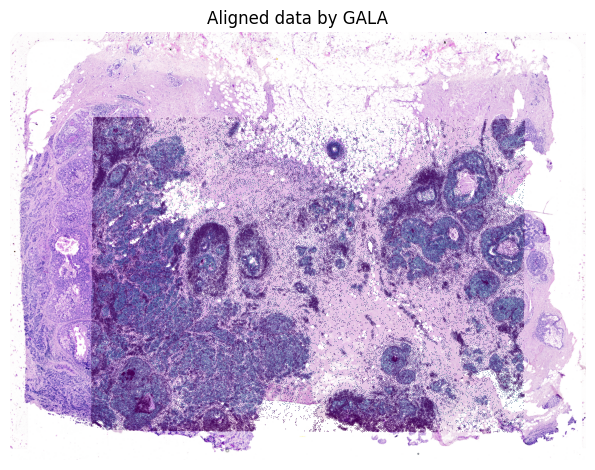

In [6]:
from GALA.utils import transform_points_target_to_source

# Load previously saved results if we choose to skip running the alignment optimization.
# with open(os.path.join(results_path, "bct.pkl"), 'rb') as f:
#    resu = pickle.load(f)

v = resu['v']
xv = resu['xv']
A = resu['A']
device = 'cpu'
### Plots results
xIj = torch.tensor(np.stack([yj,xj],1),device = device)
tpointsI= transform_points_target_to_source(xv,v,A, xIj)

#switch from row column coordinates (y,x) to (x,y)
xlddmm = tpointsI[:,1].detach().numpy()
ylddmm = tpointsI[:,0].detach().numpy()

fig,ax = plt.subplots()
ax.imshow(img)
ax.scatter(xlddmm,ylddmm, s= 1, alpha= 1,c = g,cmap = 'viridis',linewidths=0,marker = '.')
ax.set_title('Aligned data by GALA')
ax.axis('off')


plt.tight_layout()
plt.show()

# Human Lung Cancer

## Load and rasterise data

In [7]:
# Source is H&E staining image
img = plt.imread(os.path.join(data_path, './HLC/Xenium_V1_Human_Lung_Cancer_FFPE_he_image.png'))
V = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
sobelx = cv2.Sobel(V, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(V, cv2.CV_64F, 0, 1, ksize=3)
I = normalize(cv2.magnitude(sobelx, sobely))
I  = I[None,...]
YI = np.array(range(I.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
XI = np.array(range(I.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.

# Target
slice2 =  ad.read_h5ad(os.path.join(data_path, './HLC/HLC.h5ad'))
g = np.array(slice2.X.sum(axis = 1))
sc.pp.normalize_total(slice2, inplace=True)
sc.pp.log1p(slice2)
### Generate the data for experiments
xj = slice2.obsm['spatial'][:,0]
yj = slice2.obsm['spatial'][:,1]
# use spatial cell density 
gj = np.array(slice2.X.sum(axis = 1))
# rasterize at 30um resolution (assuming positions are in um units) and plot
XJ,YJ,J = rasterize(xj,yj,g = gj, dx=30)

xI = [YI,XI]
xJ = [YJ,XJ]


/home/zeng/anaconda3/envs/tao/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/zeng/anaconda3/envs/tao/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:235: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


0 of 278659
10000 of 278659
20000 of 278659
30000 of 278659
40000 of 278659
50000 of 278659
60000 of 278659
70000 of 278659
80000 of 278659
90000 of 278659
100000 of 278659
110000 of 278659
120000 of 278659
130000 of 278659
140000 of 278659
150000 of 278659
160000 of 278659
170000 of 278659
180000 of 278659
190000 of 278659
200000 of 278659
210000 of 278659
220000 of 278659
230000 of 278659
240000 of 278659
250000 of 278659
260000 of 278659
270000 of 278659
278658 of 278659


# GALA

In [8]:
rIy = xI[0].max() - xI[0].min()
rIx = xI[1].max() - xI[1].min()
rJy = xJ[0].max() - xJ[0].min()
rJx = xJ[1].max() - xJ[1].min()
sx_range = rIx / rJx if rIx > rJx else rJx / rIx  
sy_range = rIy / rJy if rIy > rJy else rJy / rIy
gene_space = [
    {'low':75,'high':105},     # angle
    {'low': 0.01, 'high': (sy_range+1.5)},     # sy
    {'low': 0.01, 'high': (sx_range+1.5)},     # sx
    {},     # ty
    {},     # tx
]

params = {'num_generations' : 1000,
          'num_iterations': 2000,
          'num_repeats': 2,
          'epV': 10.0,
          'a': 20.0,
          'sigmaR':5e4,
          'sigmaM': I.std(),
          'sigmaB': J.std(),
          'random_seed': 42
          }

resu = gala(xI,I,xJ,J,gene_space = gene_space, **params)

start = time.time()
resu = gala(xI,I,xJ,J,gene_space = gene_space, **params)
print('Alignment Runtime: ' + str(time.time() - start)) 


# save resu and copy results to CPU if gala runs on GPU.
if torch.cuda.is_available():
    resu = to_cpu(resu)
    
# [with open(os.path.join(results_path, "lung.pkl"), 'wb') as f:
#     pickle.dump(resu, f)]


Iteration 1 of 2
Generation = 200
Fitness    = 0.0004940565843192497
Change     = -4.0020538424222836e-05
Generation = 400
Fitness    = 0.0004968223898068554
Change     = 2.7658054876057107e-06
Generation = 600
Fitness    = 0.0004968223898068554
Change     = 0.0
Generation = 800
Fitness    = 0.0004977813343929297
Change     = 9.589445860743026e-07
Generation = 1000
Fitness    = 0.0004981490154328794
Change     = 3.6768103994972746e-07
Best transformation: angle=89.51, sx=2.75, sy=2.73, tx=-218.03, ty=-174.76
0 of 2000
500 of 2000
1000 of 2000
1500 of 2000
1999 of 2000
Iteration 2 of 2
Generation = 200
Fitness    = 0.0004940565843192497
Change     = -4.092431113629741e-06
Generation = 400
Fitness    = 0.0004968223898068554
Change     = 2.7658054876057107e-06
Generation = 600
Fitness    = 0.0004968223898068554
Change     = 0.0
Generation = 800
Fitness    = 0.0004977813343929297
Change     = 9.589445860743026e-07
Generation = 1000
Fitness    = 0.0004981490154328794
Change     = 3.67681039

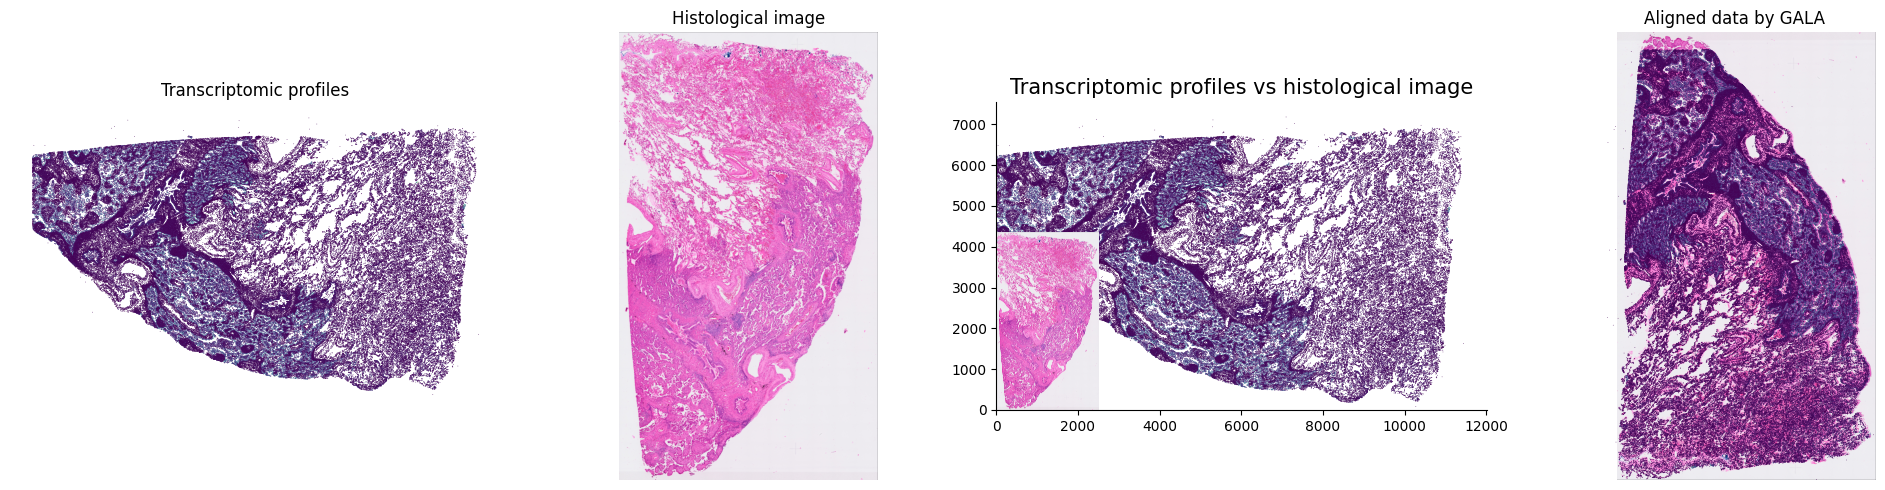

In [9]:
# Load previously saved results if we choose to skip running the alignment optimization.
# with open(os.path.join(results_path, "lung.pkl"), 'rb') as f:
#    resu = pickle.load(f)

v = resu['v']
xv = resu['xv']
A = resu['A']
device = 'cpu'
### Plots results
xIj = torch.tensor(np.stack([yj,xj],1),device = device)
tpointsI= transform_points_target_to_source(xv,v,A, xIj)

#switch from row column coordinates (y,x) to (x,y)
xlddmm = tpointsI[:,1].detach().numpy()
ylddmm = tpointsI[:,0].detach().numpy()


fig,axs = plt.subplots(1,4,figsize = (20,5))
# Expression
axs[0].scatter(xj,yj,s = ps,alpha = 1,c = g,cmap = 'viridis',linewidths=0,marker = '.')
axs[0].axis('off')
axs[0].set_title('Transcriptomic profiles')
axs[0].set_aspect('equal') 
# Image
axs[1].imshow(img)
axs[1].axis('off')
axs[1].set_title('Histological image')
axs[1].set_aspect('equal') 
axs[1].invert_yaxis()
# ST and Image
axs[2].imshow(img,zorder = 1)
axs[2].scatter(xj,yj,s = ps,alpha = 1,zorder = 0,c = g,cmap = 'viridis',linewidths=0,marker = '.')
axs[2].set_title('Transcriptomic profiles vs histological image',fontsize = fs)
#ax.axis('off')
axs[2].invert_yaxis()
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)


axs[3].imshow(img)
axs[3].scatter(xlddmm,ylddmm, s= 1, alpha= 1,c = g,cmap = 'viridis',linewidths=0,marker = '.')
axs[3].set_title('Aligned data by GALA')
axs[3].axis('off')


plt.tight_layout()
plt.show()



